Get dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns
import gower
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('../song_features.csv')
df.head()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genres
0,0HZk0QsXPhMNAWNDR3rYE8,0.4700,0.364,0.378,0.0,7,0.3390,-7.381,0,0.0331,89.918,3,0.366,a-cappella
1,6tkbKjaHRL2ZG5wtmHzXgn,0.7640,0.556,0.412,0.0,7,0.0902,-10.224,1,0.0992,84.778,4,0.811,a-cappella
2,4z8sz6E4YyFuEkv5o7IJni,0.3020,0.497,0.312,0.0,11,0.0968,-9.088,0,0.0269,105.036,4,0.177,a-cappella
3,6XamqE26MOlAoXs1LZr8AU,0.3080,0.674,0.517,0.0,2,0.0896,-7.147,1,0.0555,120.127,4,0.476,a-cappella
4,5glU2EWqa5hpYqGPboSNjV,0.0243,0.419,0.817,0.0,2,0.2510,-4.704,1,0.0468,78.107,4,0.317,a-cappella


Histogram

array([[<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>],
       [<AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'liveness'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'speechiness'}>,
        <AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'valence'}>]], dtype=object)

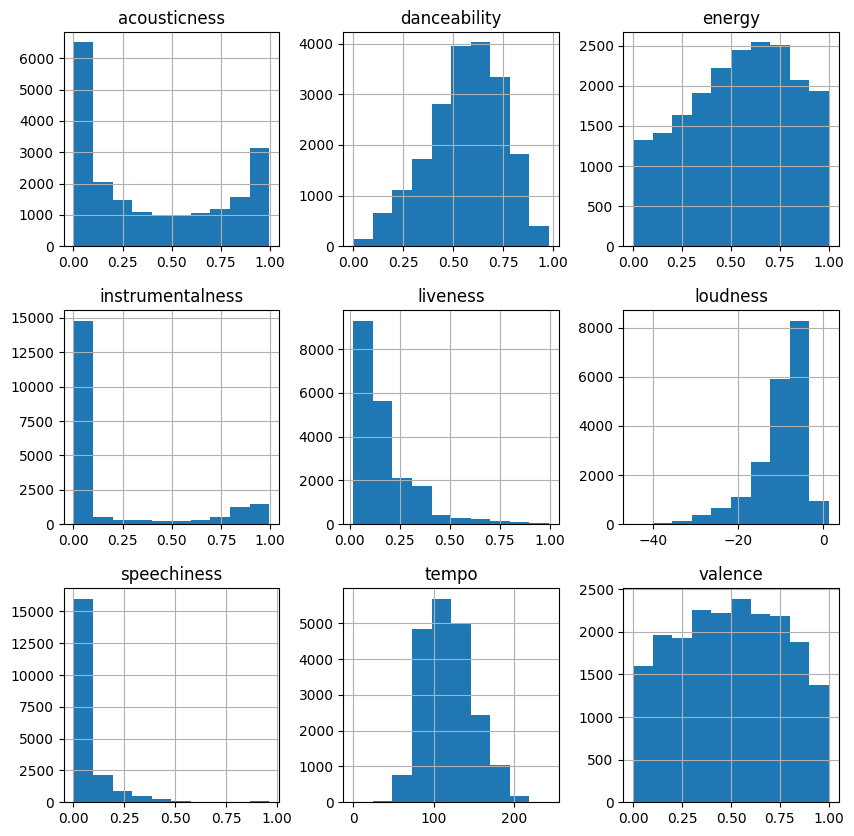

In [3]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
df[features].hist(figsize=(10,10))

Heatmap

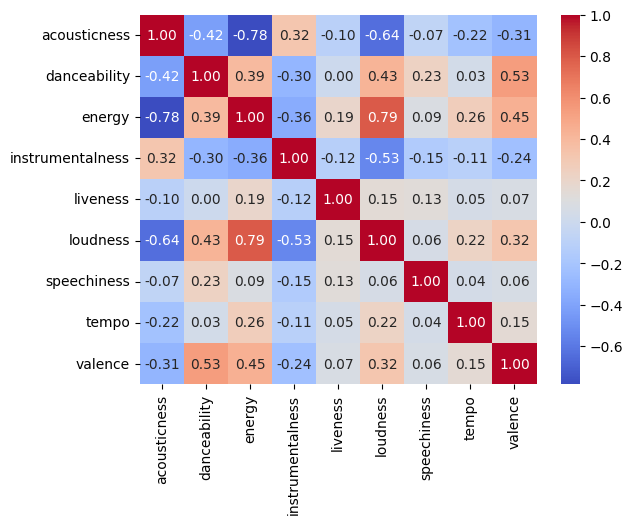

In [4]:
dataplot = sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap='coolwarm')

Box plot for features

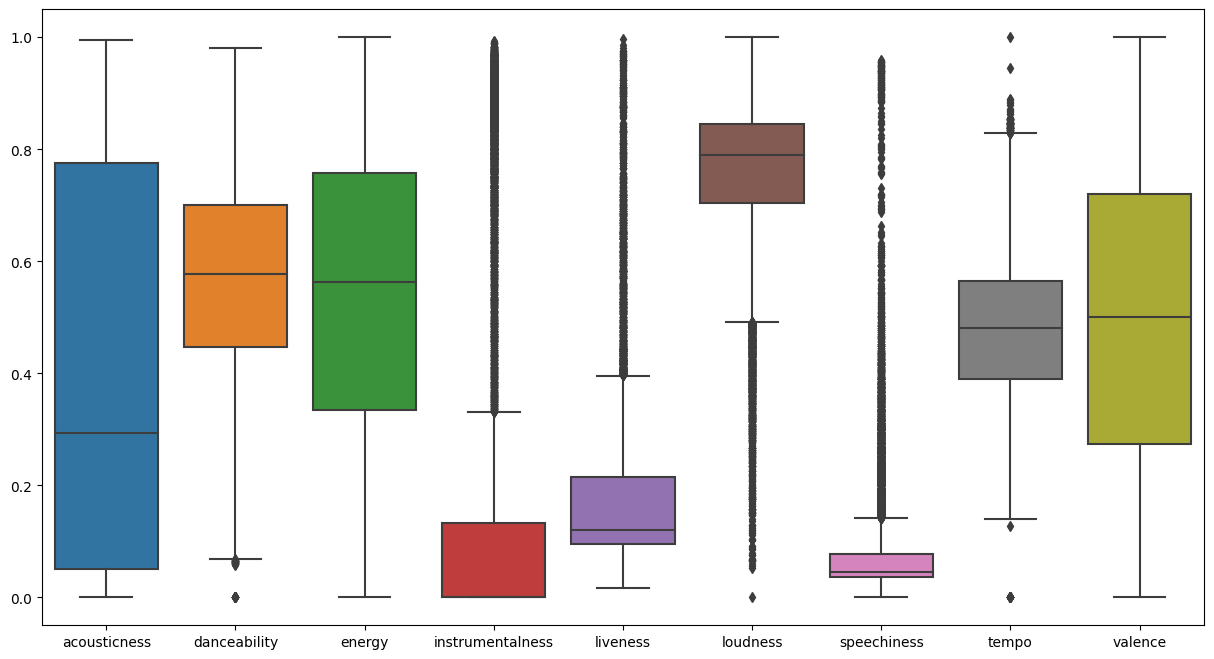

In [5]:

# Scale tempo and loudness to [0, 1]
temp = df.copy(deep=True)
for col in ['loudness', 'tempo']:
    temp[col] = ((temp[col] - temp[col].min()) / (temp[col].max() - temp[col].min()))
sns.boxplot(data=temp[features])
# Resize plot
plt.gcf().set_size_inches(15, 8)
plt.show()

Remove outliers

In [6]:
# Remove any data with tempo = 0
no_out_df = df[df['tempo'] != 0]
# Remove any data with time_signature = 0
no_out_df = no_out_df[no_out_df['time_signature'] != 0]
# Remove key, genres, id
no_out_df = no_out_df.drop(['key', 'id'], axis=1)
# Subset data to include only 500 songs per genre
sub_df = []
for genre in no_out_df['genres'].unique():
    sub_df.append(no_out_df[no_out_df['genres'] == genre].sample(500, random_state=1))
sub_df = pd.concat(sub_df)
sub_df.drop('genres', axis=1, inplace=True)
sub_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
10007,0.949,0.214,0.0803,0.000008,0.0974,-16.464,1,0.0388,115.816,1,0.124
10109,0.320,0.559,0.6250,0.000000,0.0399,-5.101,1,0.0493,132.078,4,0.646
452,0.763,0.268,0.1710,0.000000,0.0685,-7.368,1,0.0294,104.639,4,0.253
368,0.935,0.155,0.1880,0.000000,0.1040,-12.075,1,0.0398,79.287,4,0.144
242,0.336,0.431,0.5440,0.000111,0.5290,-8.796,1,0.0310,87.995,4,0.409


Scale data

In [7]:
# Scale tempo and loudness to [0, 1] using min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = sub_df.copy(deep=True)
scaled_df[['loudness', 'tempo']] = scaler.fit_transform(scaled_df[['loudness', 'tempo']])
# Rescale time_signature to [0, 1] but counts in the frequency of each time signature
freq = scaled_df['time_signature'].value_counts(normalize=True)
scaled_df['time_signature'] = scaled_df['time_signature'].apply(lambda x: freq[x])
scaled_df.head()


,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
10007,0.949,0.214,0.0803,0.000008,0.0974,0.592680,1,0.0388,0.411616,0.0111,0.124
10109,0.320,0.559,0.6250,0.000000,0.0399,0.852614,1,0.0493,0.495404,0.8614,0.646
452,0.763,0.268,0.1710,0.000000,0.0685,0.800755,1,0.0294,0.354027,0.8614,0.253
368,0.935,0.155,0.1880,0.000000,0.1040,0.693080,1,0.0398,0.223403,0.8614,0.144
242,0.336,0.431,0.5440,0.000111,0.5290,0.768089,1,0.0310,0.268270,0.8614,0.409


Clustering with Hierachical Clustering

In [8]:
distance_matrix = gower.gower_matrix(scaled_df)
distance_matrix

array([[0.        , 0.31755418, 0.16108641, ..., 0.34011093, 0.3714167 ,
        0.3795545 ],
       [0.31755418, 0.        , 0.16876085, ..., 0.20750946, 0.1838466 ,
        0.3620698 ],
       [0.16108641, 0.16876085, 0.        , ..., 0.2336911 , 0.24521348,
        0.32448152],
       ...,
       [0.34011093, 0.20750946, 0.2336911 , ..., 0.        , 0.07684825,
        0.19441053],
       [0.3714167 , 0.1838466 , 0.24521348, ..., 0.07684825, 0.        ,
        0.23294024],
       [0.3795545 , 0.3620698 , 0.32448152, ..., 0.19441053, 0.23294024,
        0.        ]], dtype=float32)

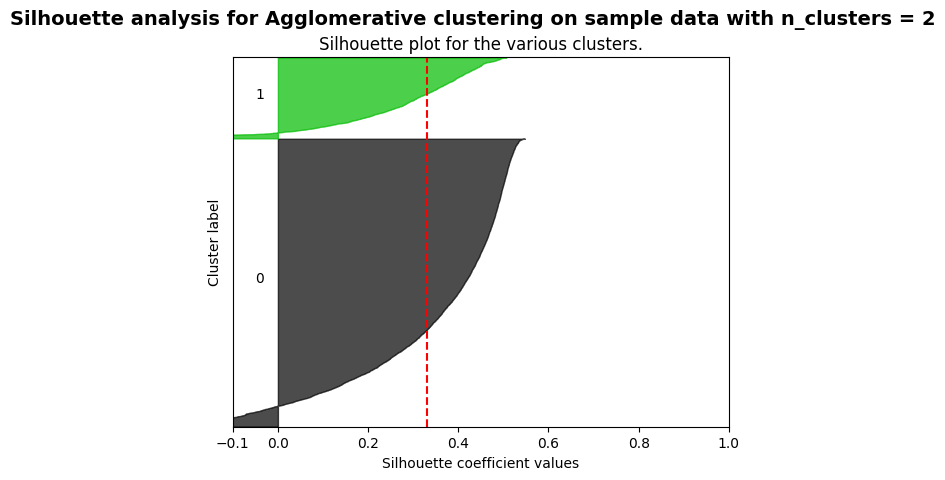

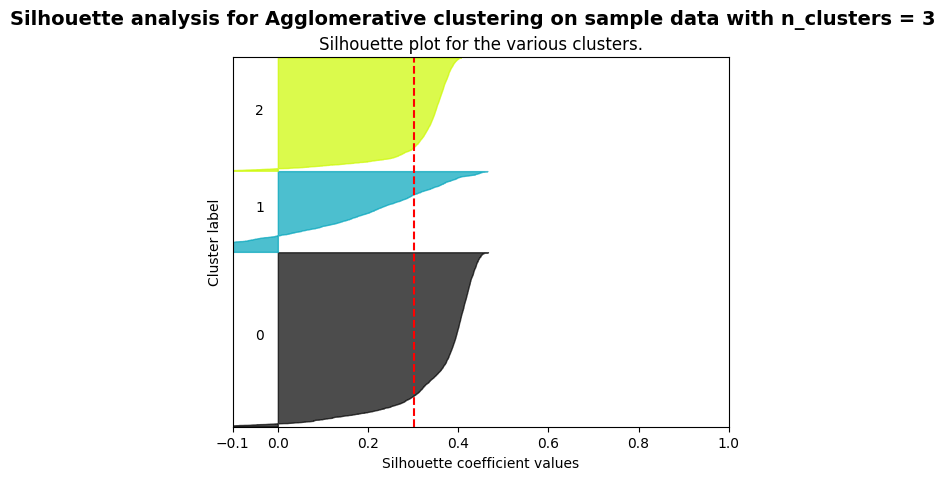

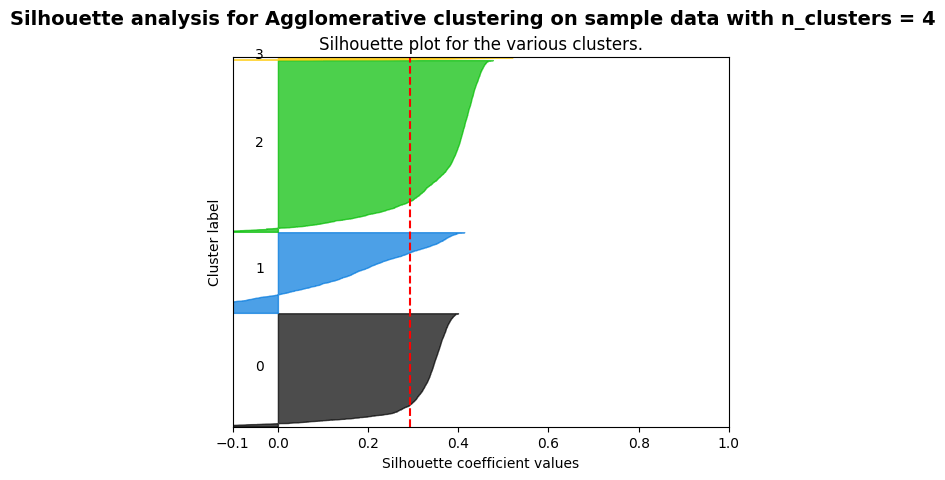

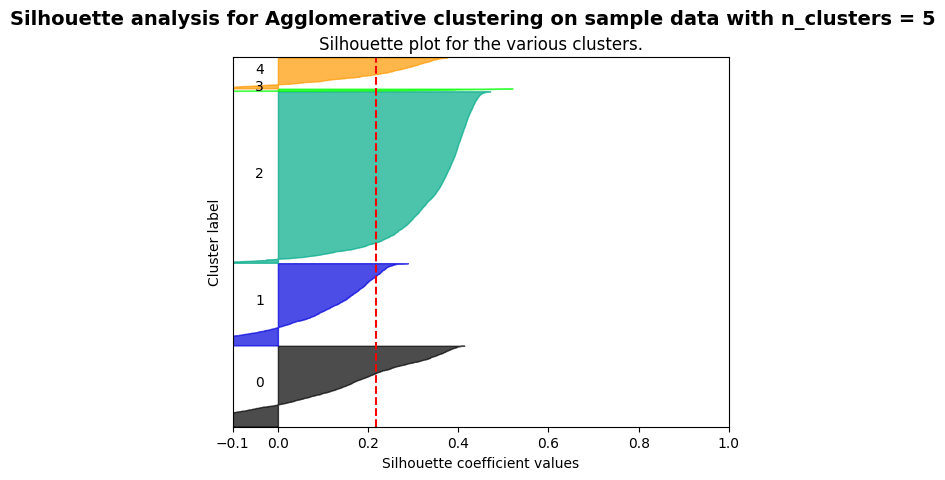

In [9]:
# Find the best number of clusters by plotting a graph of silhouette score
k_cand = range(2, 6)
for k in k_cand:
    plt.xlim((-0.1, 1.0))
    plt.ylim((0, len(distance_matrix) + (k + 1) * 10))
    model = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=k)
    clusters = model.fit_predict(distance_matrix)
    score = metrics.silhouette_score(distance_matrix, clusters, metric='precomputed')
    samples = metrics.silhouette_samples(distance_matrix, clusters, metric='precomputed')
    y_lower = 10
    for i in range(k):
        ith_cluster_sil_values = samples[clusters == i]
        ith_cluster_sil_values.sort()
        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.axvline(x=score, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title("Silhouette plot for the various clusters.")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.suptitle(("Silhouette analysis for Agglomerative clustering on sample data "
                    "with n_clusters = %d" % k), fontsize=14, fontweight='bold')
    plt.show()


In [10]:
model = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=2)
clusters = model.fit_predict(distance_matrix)
sub_df['clusters'] = clusters
sub_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,clusters
10007,0.949,0.214,0.0803,0.000008,0.0974,-16.464,1,0.0388,115.816,1,0.124,1
10109,0.320,0.559,0.6250,0.000000,0.0399,-5.101,1,0.0493,132.078,4,0.646,0
452,0.763,0.268,0.1710,0.000000,0.0685,-7.368,1,0.0294,104.639,4,0.253,1
368,0.935,0.155,0.1880,0.000000,0.1040,-12.075,1,0.0398,79.287,4,0.144,1
242,0.336,0.431,0.5440,0.000111,0.5290,-8.796,1,0.0310,87.995,4,0.409,0


Investigate the clusters

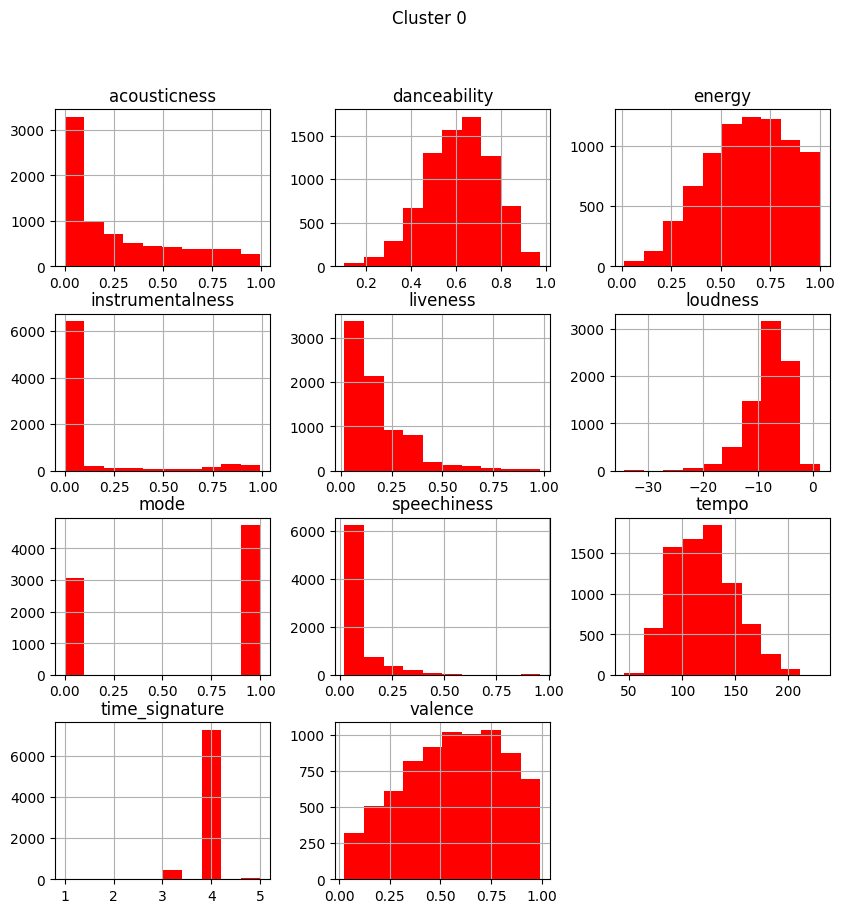

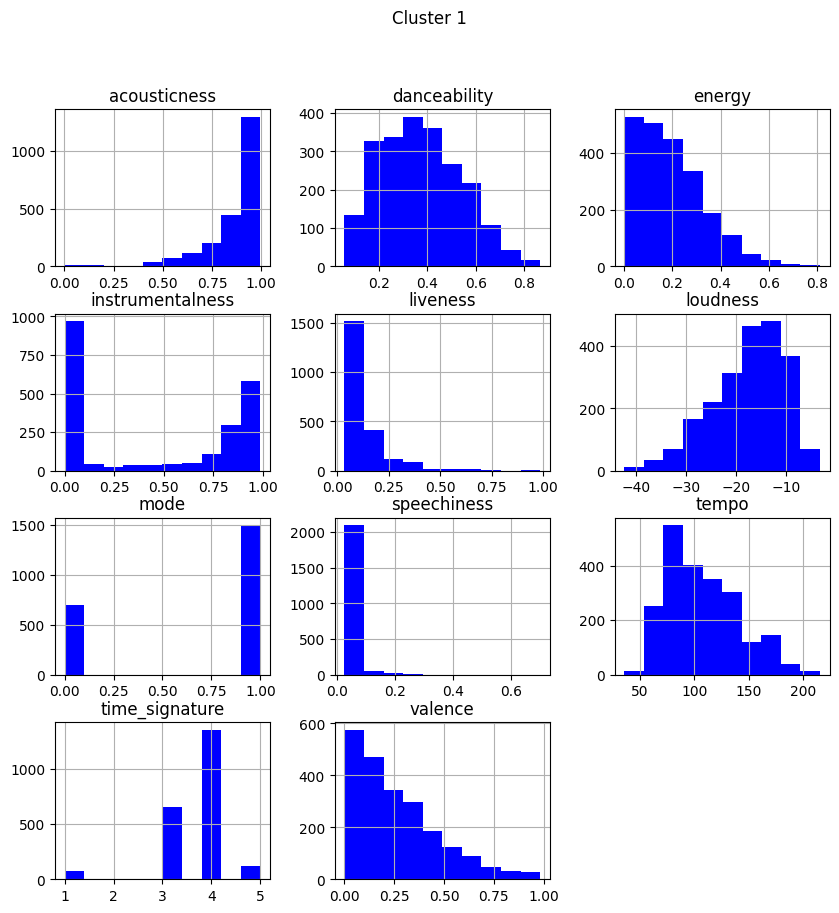

In [11]:
# Plot histogram for each feature in each cluster
plot_features = sub_df.drop(['clusters'], axis=1).columns
for k in range(0, 2):
    color = ['red', 'blue']
    sub_df[sub_df['clusters'] == k][plot_features].hist(figsize=(10,10), color=color[k])
    plt.suptitle('Cluster ' + str(k))

Investigate the difference between clusters

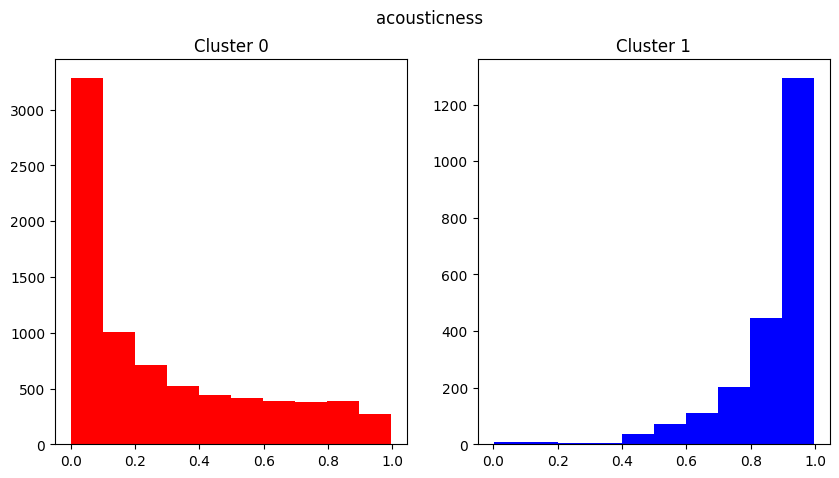

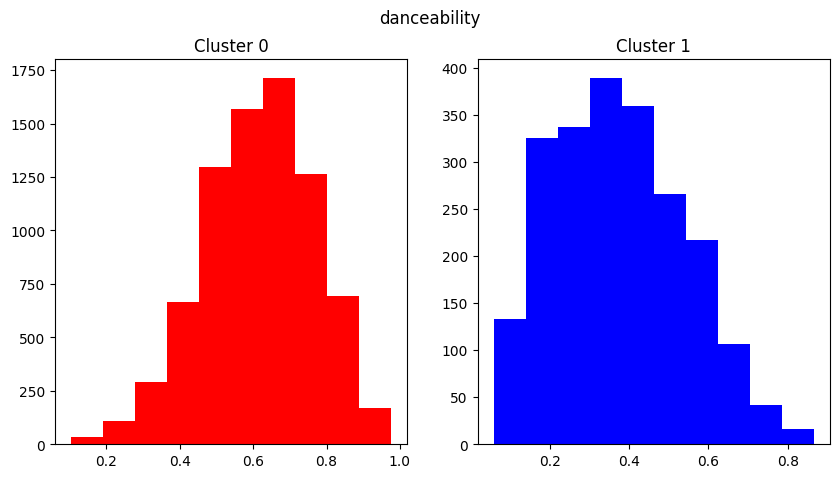

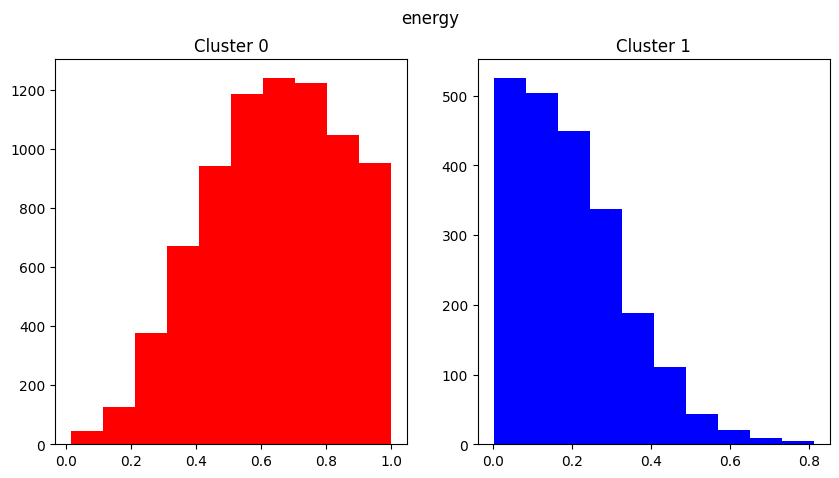

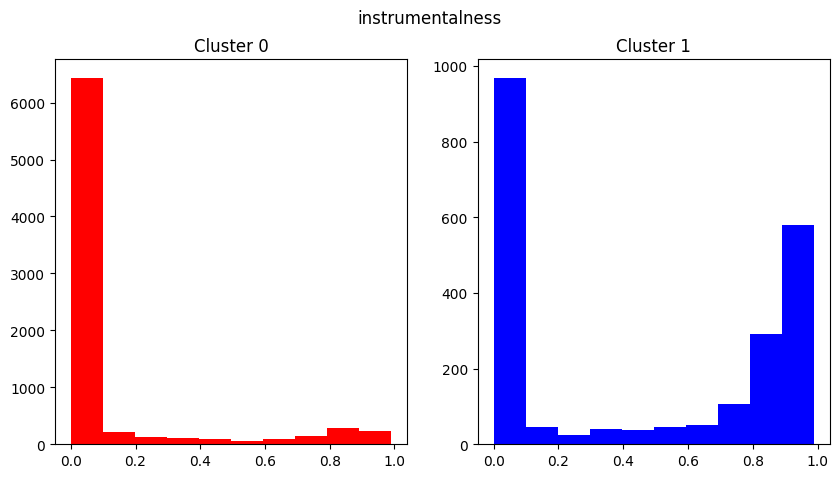

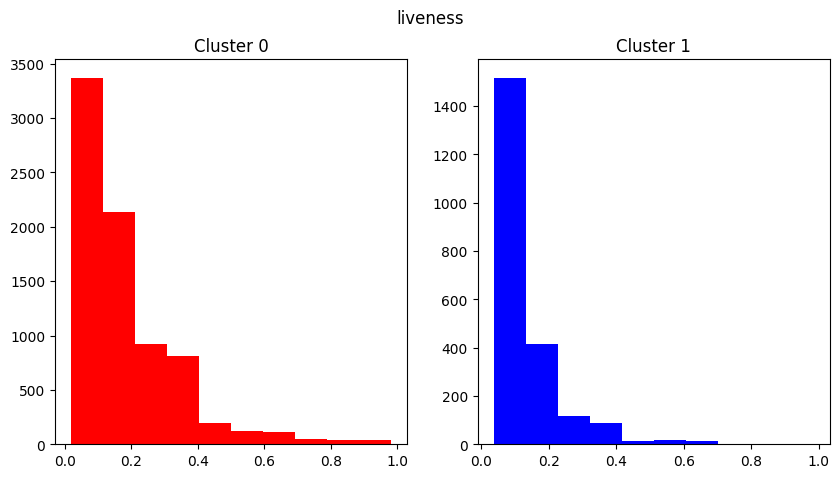

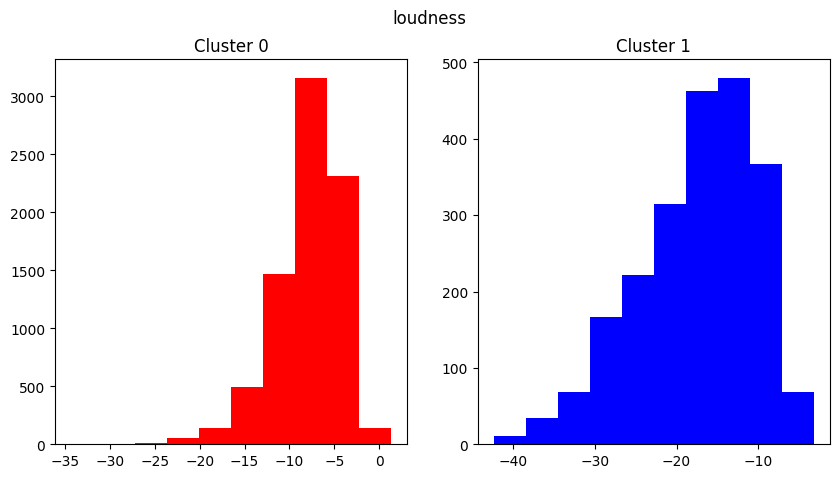

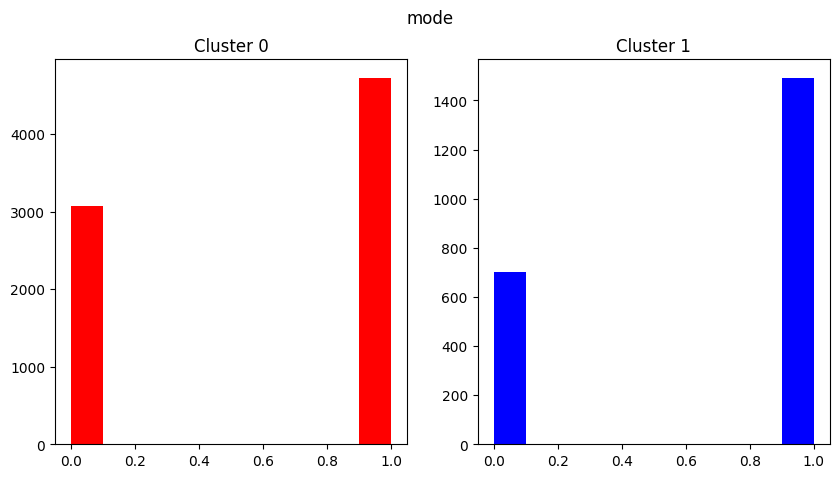

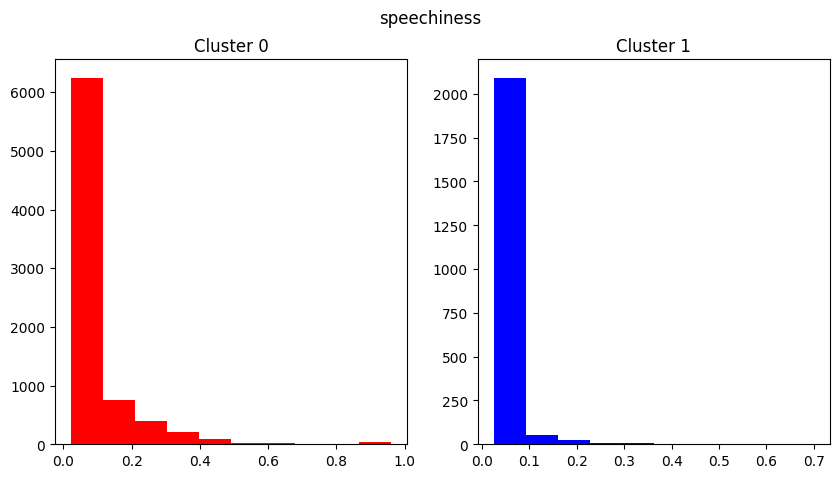

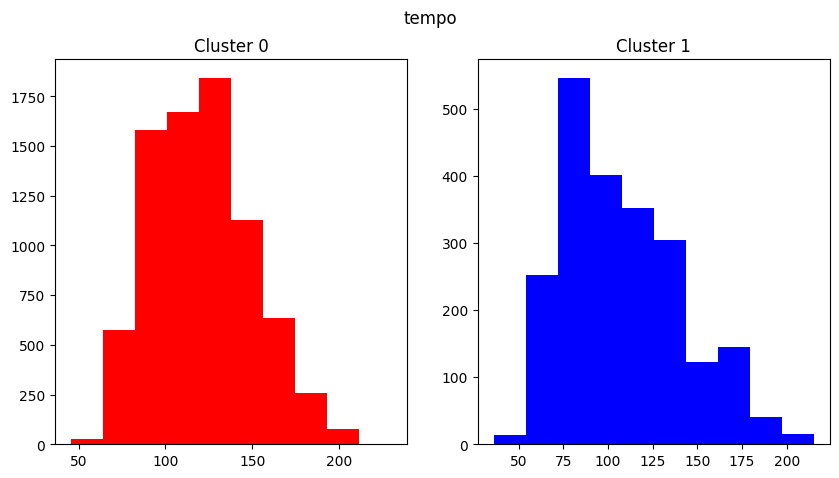

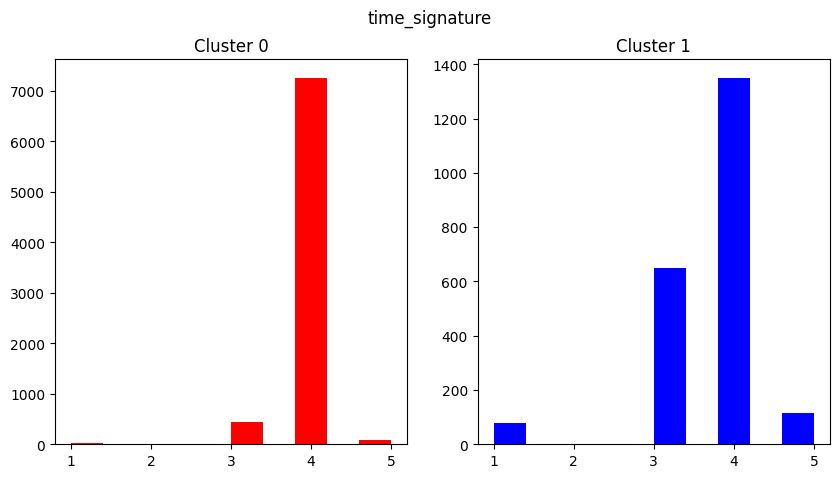

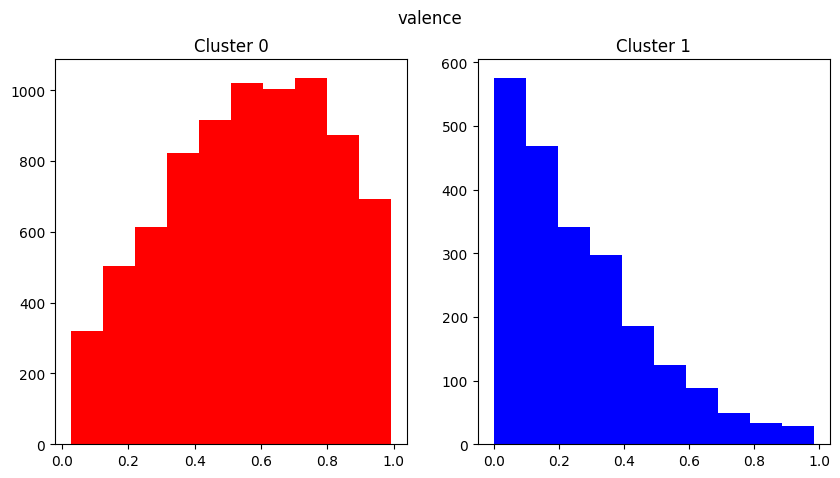

In [22]:
# Plot histogram of two clusters side by side for each feature
for feature in plot_features:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(sub_df[sub_df['clusters'] == 0][feature], color='red')
    plt.title('Cluster 0')
    plt.subplot(1, 2, 2)
    plt.hist(sub_df[sub_df['clusters'] == 1][feature], color='blue')
    plt.title('Cluster 1')
    plt.suptitle(feature)

# Remark
- Most tracks in cluster 0 score 0 only a few have high acousticness while the opposite happen in cluster 1 -> tracks from cluster 1 are more likely to be acoustic
- The average danceability of cluster 0 is seemingly higher than cluster 1 -> tracks from cluster 0 are more suitable for dancing 
- Most tracks from cluster 0 has energy level from 0.5 to 1 while cluster 1 range from 0 to around 0.5 -> tracks in cluster 0 tend to be faster, louder and noisier
- Tracks from cluster 0 mostly have 0 instrumentalness while about 50% of cluster 2's tracks have instrumentalness higher than 0.5, indicating they are instrumental tracks
- Both cluster have low liveness score, which indicates the majority of the tracks are not live performances 
- Tracks in cluster 0 often have loudness of over -10dB whereas most tracks in cluster 1 have loudness of approximately -10dB or lower -> tracks from cluster 0 tend to be louder as pointed out when discussing energy feature
- 2 clusters' mode distribution is more or less the same
- Most of the tracks from both cluster have 0 or very low level of speechiness ->  they are most likely music and other non-speech-like tracks
- The average bpm of cluster 0 is higher than cluster 1 -> tracks from cluster 0 are faster 
- Most tracks have time signature of 4, however about 20% of tracks in cluster 1 have time signature of 3  
- Tracks from cluster 0 has relatively high average valance while in cluster 1 the majority are under 0.5 -> tracks from cluster 0 should sound more positive (e.g. happy, cheerful, euphoric)
# Conclusion
- Cluster 0 is for fast, cheerful, energetic songs and cluster 1 is made of rather slow, sad or peaceful music 
- From this we can generate two playlists of user's favorite songs and name them something like "For party" and "For chilling"



In [14]:
sil_score = metrics.silhouette_score(distance_matrix, clusters, metric='precomputed')
print("Silhouette score: ", sil_score)

Silhouette score:  0.33055273


Clustering with the number of clusters being the number of genres

In [15]:
model = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=20)
clusters = model.fit_predict(distance_matrix)
sub_df['clusters'] = clusters
sub_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,clusters
10007,0.949,0.214,0.0803,0.000008,0.0974,-16.464,1,0.0388,115.816,1,0.124,18
10109,0.320,0.559,0.6250,0.000000,0.0399,-5.101,1,0.0493,132.078,4,0.646,8
452,0.763,0.268,0.1710,0.000000,0.0685,-7.368,1,0.0294,104.639,4,0.253,3
368,0.935,0.155,0.1880,0.000000,0.1040,-12.075,1,0.0398,79.287,4,0.144,3
242,0.336,0.431,0.5440,0.000111,0.5290,-8.796,1,0.0310,87.995,4,0.409,9


In [16]:
# Bring back the genres
sub_df['genres'] = df['genres']
# For each genre, find the most common cluster
genre_cluster = []
for genre in sub_df['genres'].unique():
    genre_cluster.append((genre, sub_df[sub_df['genres'] == genre]['clusters'].mode()[0]))
# Encode genre according to the genre_cluster
genre_cluster = pd.DataFrame(genre_cluster, columns=['genres', 'clusters'])
merged = pd.merge(sub_df, genre_cluster, on='genres')
# Rename column
merged.rename(columns={'clusters_x': 'pred_cluster', 'clusters_y': 'true_cluster'}, inplace=True)
merged.head()


,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,pred_cluster,genres,true_cluster
0,0.949,0.214,0.0803,0.000008,0.0974,-16.464,1,0.0388,115.816,1,0.124,18,a-cappella,8
1,0.320,0.559,0.6250,0.000000,0.0399,-5.101,1,0.0493,132.078,4,0.646,8,a-cappella,8
2,0.763,0.268,0.1710,0.000000,0.0685,-7.368,1,0.0294,104.639,4,0.253,3,a-cappella,8
3,0.935,0.155,0.1880,0.000000,0.1040,-12.075,1,0.0398,79.287,4,0.144,3,a-cappella,8
4,0.336,0.431,0.5440,0.000111,0.5290,-8.796,1,0.0310,87.995,4,0.409,9,a-cappella,8


In [17]:
sil_score = metrics.silhouette_score(distance_matrix, merged['pred_cluster'], metric='precomputed')
print(metrics.classification_report(merged['true_cluster'], merged['pred_cluster']))
print('Silhouette score: ' + str(sil_score))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.25      0.20      0.22      1000
           2       0.00      0.00      0.00         0
           3       0.49      0.28      0.36      1500
           4       0.35      0.29      0.32       500
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.82      0.32      0.46      6000
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.22      0.35      0.27      1000
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/home/deathmachine/spotify-rec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deathmachine/spotify-rec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deathmachine/spotify-rec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
